In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import random
import numpy as np
import torchvision.transforms.functional as TF

class OneClassDatasetFashionMNIST(torchvision.datasets.FashionMNIST):
    def __init__(self, root_dir, real_class=1, transform=None, train=True, download=True):
        super().__init__(root=root_dir, transform=transform, train=train, download=download)
        self.real_class = real_class
        self.samples = []
        for i in range(len(self.data)):
            if self.targets[i] == self.real_class:
                self.samples.append((self.data[i], self.targets[i]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        data = self.samples[idx]
        image = data[0].unsqueeze(0)
        image = image / 255

        if self.transform:
            image = self.transform(image)

        label = random.randint(0, 3)
        image = TF.rotate(image, label * 90)

        return image, label

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

class_1 = OneClassDatasetFashionMNIST(root_dir='.', real_class=2, transform=transform, train=True, download=False)

In [3]:
image, label = class_1[0]

In [4]:
len(class_1)

6000

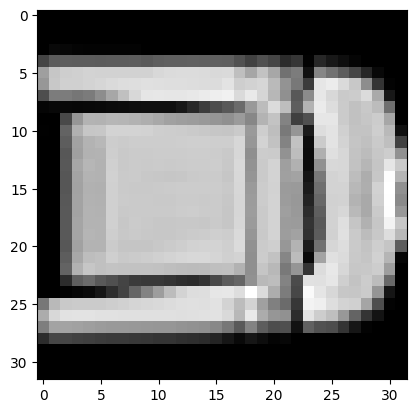

In [5]:
plt.imshow(image.permute(1, 2, 0).numpy(), cmap='gray');

In [6]:
class IdentityBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(IdentityBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.conv_residual = nn.Conv2d(in_channels, out_channels, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn2(x)
        residual = self.conv_residual(input)
        x = self.activation(x+residual)
        return x

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2, stride=2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.conv_residual = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.bn_residual = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn2(x)
        residual = self.conv_residual(input)
        residual = self.bn_residual(residual)
        x = self.activation(x+residual)
        return x

class ConvGroup(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(ConvGroup, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        if stride == 2:
            self.block1 = ConvBlock(in_channels, out_channels, kernel_size)
        else:
            self.block1 = IdentityBlock(in_channels, out_channels, kernel_size)
        self.block2 = IdentityBlock(out_channels, out_channels, kernel_size)
        self.block3 = IdentityBlock(out_channels, out_channels, kernel_size)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return x


class Net(nn.Module):
    def __init__(self, num_of_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.group1 = ConvGroup(in_channels=8, out_channels=16, kernel_size=3)
        self.group2 = ConvGroup(in_channels=16, out_channels=32, kernel_size=3, stride=2)
        self.group3 = ConvGroup(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.fc = nn.Linear(64*8*8, num_of_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.group1(x)
        x = self.group2(x)
        x = self.group3(x)
        x = x.view(-1, 64*8*8)
        x = self.fc(x)
        return x

In [7]:
net = Net(num_of_classes=4)

In [38]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    tloss = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        tloss += loss.item()
    return tloss / len(train_loader)

def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    tloss = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            tloss += loss.item()

    return tloss / len(test_loader), correct / total

def test_model(model, real_test_loader, ano_test_loaders):
    model.eval()

    def get_score(loader):
        lopprobs = []
        with torch.no_grad():
            for data in loader:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                logp = F.softmax(outputs, dim=1)[list(range(images.shape[0])), labels]
                lopprobs.append(logp.cpu().numpy())
        return np.concatenate(lopprobs)



    real_lopprobs = get_score(real_test_loader)
    ano_lopprobs = [get_score(loader) for loader in ano_test_loaders]
    aurocs = []
    for i in range(9):
        y_true = np.concatenate([np.ones_like(real_lopprobs), np.zeros_like(ano_lopprobs[i])])
        y_score = np.concatenate([real_lopprobs, ano_lopprobs[i]])

        fpr, tpr, roc_thresholds = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        aurocs.append(roc_auc)

    return np.mean(aurocs)

def select_th(model, real_test_loader, ano_test_loader):
    model.eval()

    def get_score(loader):
        lopprobs = []
        with torch.no_grad():
            for data in loader:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                logp = F.softmax(outputs, dim=1)[list(range(images.shape[0])), labels]
                lopprobs.append(logp.cpu().numpy())
        return np.concatenate(lopprobs)

    real_lopprobs = get_score(real_test_loader)
    ano_lopprobs = get_score(ano_test_loader)
    y_true = np.concatenate([np.ones_like(real_lopprobs), np.zeros_like(ano_lopprobs)])
    y_score = np.concatenate([real_lopprobs, ano_lopprobs])

    lam = np.linspace(0.001, 0.99, 10)
    for l in lam:
      b_score = y_score >= l
      correct = (b_score == y_true).sum().item()
      acc = correct / len(y_true)

      print(acc, l)



def main(real_class):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((32, 32)),
        torchvision.transforms.Normalize((0.5,), (0.5,))
        ])

    train_dataset = OneClassDatasetFashionMNIST(root_dir='.', real_class=real_class, transform=transform, train=True, download=True)
    val_dataset = OneClassDatasetFashionMNIST(root_dir='.', real_class=real_class, transform=transform, train=False, download=True)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)


    real_test_dataset = OneClassDatasetFashionMNIST(root_dir='.', real_class=real_class, transform=transform, train=False, download=True)
    real_test_loader = torch.utils.data.DataLoader(real_test_dataset, batch_size=32, shuffle=False)
    ano_test_datasets = []
    ano_test_loaders = []
    for i in range(10):
        if i == real_class:
            continue
        ano_test_datasets.append(OneClassDatasetFashionMNIST(root_dir='.', real_class=i, transform=transform, train=False, download=True))
        ano_test_loaders.append(torch.utils.data.DataLoader(ano_test_datasets[-1], batch_size=32, shuffle=False))

    model = Net(num_of_classes=4)
    model = model.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(2):
        tloss = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        print(f'Epoch {epoch} Train Loss: {tloss} Test Loss: {val_loss} Test Accuracy: {val_acc}')

    aurocs = test_model(model, real_test_loader, ano_test_loaders)
    print('AUROCs:', aurocs)
    # print('AUCPRCs:', aucprcs)
    # print('AUCPRCs Anom:', aucprcs_anom)

    select_th(model, real_test_loader, ano_test_loaders[8])


In [35]:
main(real_class=1)

Epoch 0 Train Loss: 0.08629892289300574 Test Loss: 0.05234836253066533 Test Accuracy: 0.982
Epoch 1 Train Loss: 0.04160032270904816 Test Loss: 0.022896085547072786 Test Accuracy: 0.99
AUROCs: 0.9917151111111111
0.5005 0.001
0.5475 0.11088888888888888
0.6245 0.22077777777777777
0.7185 0.33066666666666666
0.816 0.44055555555555553
0.8805 0.5504444444444444
0.9295 0.6603333333333333
0.9545 0.7702222222222221
0.9735 0.8801111111111111
0.9805 0.99


In [39]:
main(real_class=1)

Epoch 0 Train Loss: 0.10411653333683213 Test Loss: 0.05094477532596642 Test Accuracy: 0.983
Epoch 1 Train Loss: 0.03633267194939609 Test Loss: 0.06957225145623624 Test Accuracy: 0.983
AUROCs: 0.9853778888888889
0.596 0.001
0.8255 0.11088888888888888
0.8835 0.22077777777777777
0.925 0.33066666666666666
0.9465 0.44055555555555553
0.9635 0.5504444444444444
0.9715 0.6603333333333333
0.972 0.7702222222222221
0.975 0.8801111111111111
0.966 0.99
